Copyright **`(c)`** 2023 Antonio Ferrigno `<s316467@polito.it>`  
[`https://github.com/s316467/Computational-Intelligence-23-24/tree/main`](https://github.com/s316467/Computational-Intelligence-23-24/tree/main)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/s316467/Computational-Intelligence-23-24/tree/main/LICENSE.md) for details.

I have worked together with Matteo Di Iorio, s316606 [`https://github.com/Matteo-Di-Iorio-s316606/Computational_Intelligence_23-24`](https://github.com/Matteo-Di-Iorio-s316606/Computational_Intelligence_23-24) 

# LAB9

Write a local-search algorithm (eg. an EA) able to solve the *Problem* instances 1, 2, 5, and 10 on a 1000-loci genomes, using a minimum number of fitness calls. That's all.

### Deadlines:

* Submission: Sunday, December 3 ([CET](https://www.timeanddate.com/time/zones/cet))
* Reviews: Sunday, December 10 ([CET](https://www.timeanddate.com/time/zones/cet))

Notes:

* Reviews will be assigned  on Monday, December 4
* You need to commit in order to be selected as a reviewer (ie. better to commit an empty work than not to commit)

In [30]:
from random import choices, random, randint, sample
import matplotlib.pyplot as plt
import numpy as np
import itertools
import lab2_lib

In [31]:
# Function to create a specific problem instance
def create_problem_instance(instance_number):
    return lab2_lib.make_problem(instance_number)

In [32]:
# Initialize a population of genomes
def initialize_population(size, length):
    return [choices([0, 1], k=length) for _ in range(size)]

# Initial Tournament selection
"""
def tournament_selection(population, fitnesses, tournament_size=3):
    selected = []
    for _ in range(2):
        tournament = sample(list(zip(population, fitnesses)), tournament_size)
        selected.append(max(tournament, key=lambda x: x[1])[0])
    return selected
"""

# Perform crossover between two parents
def crossover(parent1, parent2, crossover_rate):
    if random() < crossover_rate:
        crossover_point = int(0.2 * len(parent1)) 
        # Using 1/5 rule, as seen in Introduction to Evolutionary Computing pag. 141
        child = parent1[:crossover_point] + parent2[crossover_point:]
        return child
    else:
        return parent1

# Mutate a genome
def mutate(genome, mutation_rate):
    mutation_indices = np.random.choice(len(genome), int(len(genome) * 0.2), replace=False)
    for i in mutation_indices:
    # Using 1/5 rule, as seen in Introduction to Evolutionary Computing pag. 141
        if random() < mutation_rate:
            genome[i] = 1 - genome[i]
    return genome

# Improved tournament selection
def tournament_selection(population, fitnesses, tournament_size):
    selected = []
    for _ in range(2):
        tournament_indices = np.random.choice(len(population), tournament_size, replace=False)
        tournament = [(population[i], fitnesses[i]) for i in tournament_indices]
        selected.append(max(tournament, key=lambda x: x[1])[0])
    return selected

# Elitism
def elitism(population, fitnesses, elite_size=2):
    sorted_population = sorted(zip(population, fitnesses), key=lambda x: x[1], reverse=True)
    return [individual for individual, _ in sorted_population[:elite_size]]

def plot_fitness_over_generations(best_fitness_history):
    plt.plot(best_fitness_history)
    plt.title("Best Fitness over Generations")
    plt.xlabel("Generation")
    plt.ylabel("Best Fitness")
    plt.grid(True)
    plt.show()

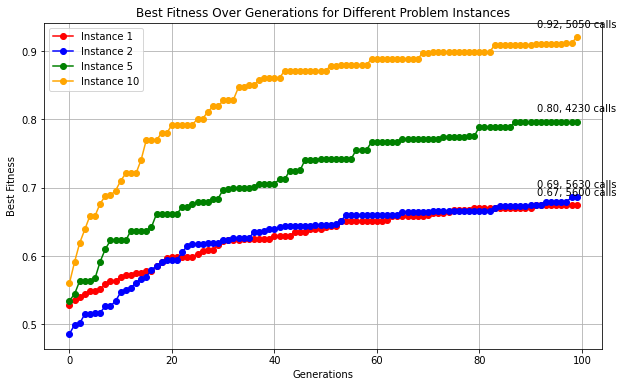

In [40]:
# Parameters (not modifiable)
genome_length = 1000
mutation_rate = 0.15 # Advised by professor
tournament_sizes = [3, 5, 7] # Advised by professor
problem_instances = [1, 2, 5, 10] # Requirement of the assignment

# Parameter (modifiable)
max_generations = [100] # Other iterations number are too long to run
population_sizes = [10] # [50, 100, 200, 500] # unuseful most of the times trying with other settings
crossover_rates = [0.6, 0.8, 1.0]
convergence_threshold = 10  # Number of generations without improvement to trigger termination

# Record keeping
best_fitness_per_instance_and_combination = {}
fitness_history_per_combination = {}
# Initialize a dictionary to store the highest fitness and configuration for each problem instance
highest_fitness_per_instance = {}

best_fitness = 0
generations_without_improvement = 0
lowest_fitness_calls = float('inf')

# Iterate over all combinations of parameters
for problem_instance_number in problem_instances:
    highest_fitness_per_instance[problem_instance_number] = (0, None, float('inf'))
    fitness_function = create_problem_instance(problem_instance_number)
    
    for population_size, crossover_rate, tournament_size in itertools.product(population_sizes, crossover_rates, tournament_sizes):
        for max_generation in max_generations:
            population = initialize_population(population_size, genome_length)
            fitness_cache = {}
            best_fitness_history = []
            best_fitness = 0
            generations_without_improvement = 0

            for generation in range(max_generation):
                fitness_values = [fitness_cache.setdefault(tuple(individual), fitness_function(individual)) for individual in population]
                best_fitness_in_generation = max(fitness_values)

                # Update the best fitness and history
                best_fitness_history.append(best_fitness_in_generation)
                if best_fitness_in_generation > best_fitness:
                    best_fitness = best_fitness_in_generation
                    generations_without_improvement = 0
                else:
                    generations_without_improvement += 1

                # Termination check (you can remove or adjust this)
                if generations_without_improvement >= convergence_threshold:
                    # If you want to run all generations, you might remove this break
                    break

                # Evolutionary operations: selection, crossover, mutation
                elite = elitism(population, fitness_values)
                new_population = elite.copy()

                while len(new_population) < population_size:
                    parent1, parent2 = tournament_selection(population, fitness_values, tournament_size)
                    child = crossover(parent1, parent2, crossover_rate)
                    child = mutate(child, mutation_rate)
                    new_population.append(child)

                population = new_population[:population_size]

            total_fitness_calls = fitness_function.calls
            key = (problem_instance_number, population_size, crossover_rate, tournament_size, max_generation)
            fitness_history_per_combination[key] = best_fitness_history
            best_fitness_per_instance_and_combination[key] = (best_fitness, total_fitness_calls)

            if best_fitness > highest_fitness_per_instance[problem_instance_number][0] or \
               (best_fitness == highest_fitness_per_instance[problem_instance_number][0] and total_fitness_calls < lowest_fitness_calls):
                highest_fitness_per_instance[problem_instance_number] = (best_fitness, key, total_fitness_calls)
                lowest_fitness_calls = total_fitness_calls


"""
# Plotting the results for each parameter combination
for key, avg_fitness_history in fitness_history_per_combination.items():
    problem_instance_number, population_size, crossover_rate, tournament_size, max_generation = key
    plt.figure()
    plt.plot(range(max_generation), avg_fitness_history, marker='o')
    title = f"Problem Instance {problem_instance_number}, Population Size={population_size}, Crossover Rate={crossover_rate}, Tournament Size={tournament_size}, Max Generations={max_generation}"
    plt.title(title)
    plt.xlabel("Generations")
    plt.ylabel("Best Fitness")
    plt.grid(True)
    plt.show()
    
# Plotting the results for each problem instance
for problem_instance_number in problem_instances:
    for params in itertools.product(population_sizes, crossover_rates, tournament_sizes):
        # Prepare data for plotting
        fitness_values = []
        for max_generation in max_generations:
            key = (problem_instance_number,) + params + (max_generation,)
            fitness_values.append(best_fitness_per_instance_and_combination[key])

        # Plot the graph for this combination of parameters and problem instance
        plt.figure()
        plt.plot(max_generations, fitness_values, marker='o')
        title = f"Problem Instance {problem_instance_number}, Population Size={params[0]}, Crossover Rate={params[1]}, Tournament Size={params[2]}"
        plt.title(title)
        plt.xlabel("Max Generations")
        plt.ylabel("Best Fitness")
        plt.grid(True)
        plt.show()
"""

# Collecting fitness histories for each problem instance
fitness_histories = {problem_instance: fitness_history_per_combination[highest_fitness_per_instance[problem_instance][1]]
                     for problem_instance in problem_instances}

# Define a list of distinct colors for each problem instance
colors = ['red', 'blue', 'green', 'orange']  # Adjust colors as needed

plt.figure(figsize=(10, 6))

# Plotting the highest fitness for each problem instance on the same graph
for i, problem_instance in enumerate(problem_instances):
    fitness_history = fitness_histories[problem_instance]
    highest_fitness, configuration, fitness_calls = highest_fitness_per_instance[problem_instance]

    # Plot the fitness history
    plt.plot(range(len(fitness_history)), fitness_history, marker='o', color=colors[i], label=f'Instance {problem_instance}')

    # Annotation for the last point
    last_gen = len(fitness_history) - 1
    last_fitness = fitness_history[-1]
    annotation_text = f"{highest_fitness:.2f}, {fitness_calls} calls"
    plt.annotate(annotation_text, (last_gen, last_fitness), textcoords="offset points", xytext=(0,10), ha='center')

plt.title("Best Fitness Over Generations for Different Problem Instances")
plt.xlabel("Generations")
plt.ylabel("Best Fitness")
plt.grid(True)
plt.legend()  # Display a legend to identify problem instances
plt.show()